# CSR Benchmark - Comparing to Bmad

In [1]:
from pmd_beamphysics import ParticleGroup
from pytao import Tao

import impact.z as IZ
from impact.tests.z.conftest import bmad_files
from impact.z.interfaces.bmad import plot_impactz_and_tao_stats

import matplotlib.pyplot as plt

## Tao

In [2]:
!cat $bmad_files/csr_bench.bmad

no_digested
BEGINNING[beta_a]  =  10
BEGINNING[beta_b]  =  10
parameter[geometry] = open
parameter[particle] = electron
parameter[e_tot] = 1000e6

bmad_com[csr_and_space_charge_on] = T

P1: Pipe, L = 0
B1: sbend, L = 3, rho = 10, csr_method = 1_dim
P2: Pipe, L = 1, csr_method = 1_dim

!This will mess up Impact-Z's drift CSR
!m1: marker, superimpose, ref = P2, ref_origin=beginning, offset = 0.1

lat: line = (P1, B1, P2)

use, lat


In [3]:
tao = Tao(lattice_file=bmad_files / "csr_bench.bmad", plot="mpl")

In [4]:
n_particle = 100_000
a_norm_emit = 1.0e-6
b_norm_emit = 1.0e-6
bunch_charge = 1e-9
sig_pz = 1e-12
sig_z = 0.3e-3  # ~1ps

ds_track_step = 0.01
n_bin = 128

cmds = [
    f"set beam_init n_particle = {n_particle}",
    "set beam_init random_engine = quasi",
    f"set beam_init a_norm_emit = {a_norm_emit}",
    f"set beam_init b_norm_emit = {b_norm_emit}",
    f"set beam_init bunch_charge = {bunch_charge}",
    f"set beam_init sig_pz = {sig_pz}",
    f"set beam_init sig_z = {sig_z}",
    f"set space_charge_com ds_track_step = {ds_track_step}",
    f"set space_charge_com n_bin = {n_bin}",
    f"set ele * ds_step = {ds_track_step}",
]

for cmd in cmds:
    res = tao.cmd(cmd)
    if res:
        print("Tao>", cmd)
        print(res)

In [5]:
tao.track_beam()

<!-- lume-impact detected Jupyter and will use HTML for rendering. -->

  0%|          | 0/4 [00:00<?, ?ele/s]

['',
 'Tao: set global track_type = beam',
 '',
 'Tao: set global track_type = single']

In [6]:
P0 = ParticleGroup(data=tao.bunch_data("beginning"))

In [7]:
Ptao = ParticleGroup(data=tao.bunch_data("end"))

## Impact-Z

In [8]:
input = IZ.ImpactZInput.from_tao(tao)

Element #2 has a fringe type of 'Basic_Bend'; to match with Impact-Z, this should be 'Full'


In [9]:
I = IZ.ImpactZ(input, initial_particles=P0)
I.input.nz = n_bin

In [10]:
%%time
output = I.run();

<!-- lume-impact detected Jupyter and will use HTML for rendering. -->

  0%|          | 0/7 [00:00<?, ?it/s]

CPU times: user 1.47 s, sys: 108 ms, total: 1.58 s
Wall time: 13.6 s


## Initial particles

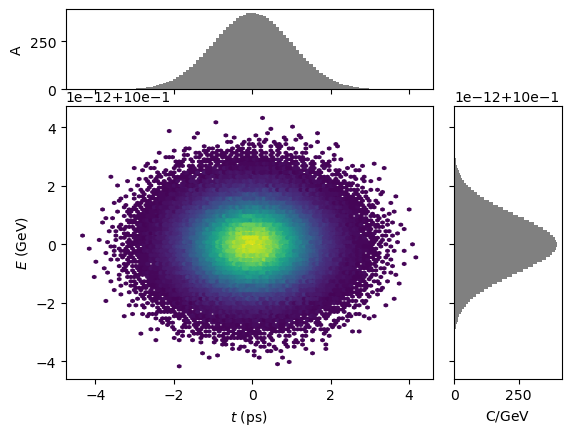

In [11]:
P0.plot("t", "energy", bins=100)

## Final particles

### Tao

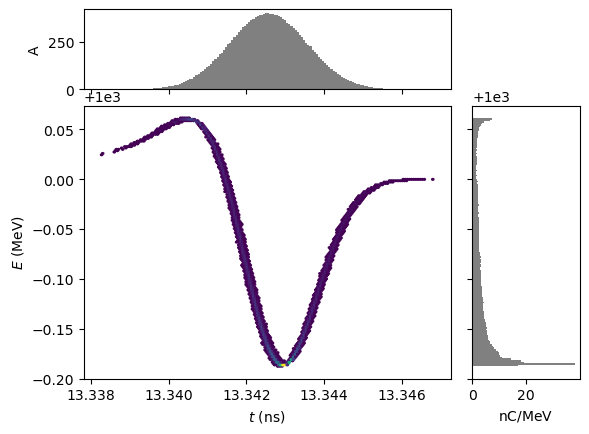

In [12]:
Ptao
Ptao.plot("t", "energy")

### IMPACT-Z

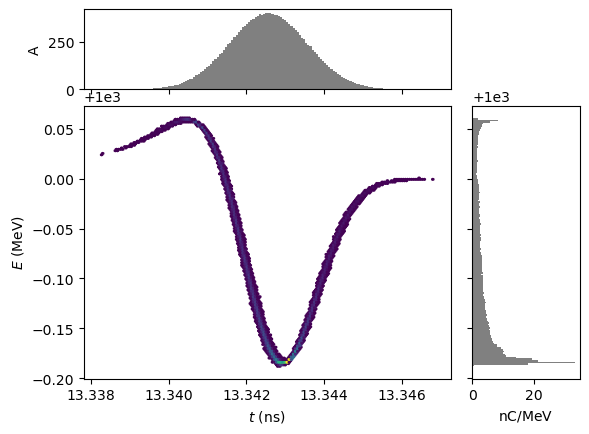

In [13]:
P2 = I.output.particles["final_particles"]
P2.plot("t", "energy")

# Compare

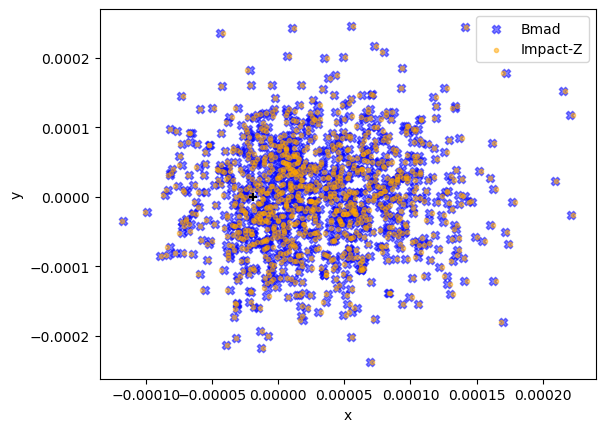

In [14]:
def compare(
    xkey="x",
    ykey="y",
    skip=1,
):
    fig, ax = plt.subplots()

    plist = (
        (Ptao, "Bmad", "X", "blue"),
        (P2, "Impact-Z", ".", "orange"),
    )

    for p, label, marker, color in plist:
        ax.scatter(
            p[xkey][::skip],
            p[ykey][::skip],
            label=label,
            marker=marker,
            alpha=0.5,
            color=color,
        )

    for p, label, marker, color in plist:
        ax.scatter(
            p["mean_" + xkey],
            p["mean_" + ykey],
            marker="+",
            color=color,
            facecolor="black",
        )

    plt.legend()

    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)


compare(skip=100)

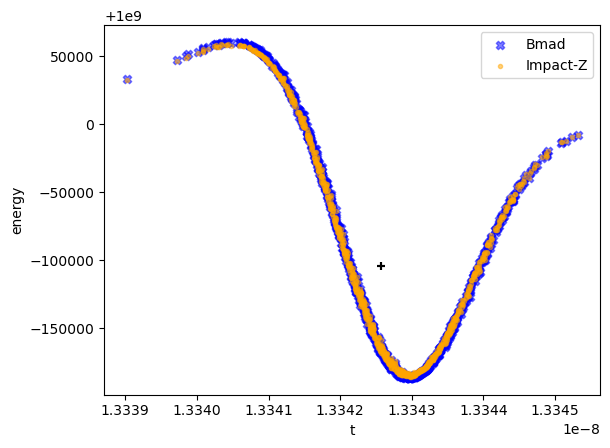

In [15]:
compare("t", "energy", skip=100)

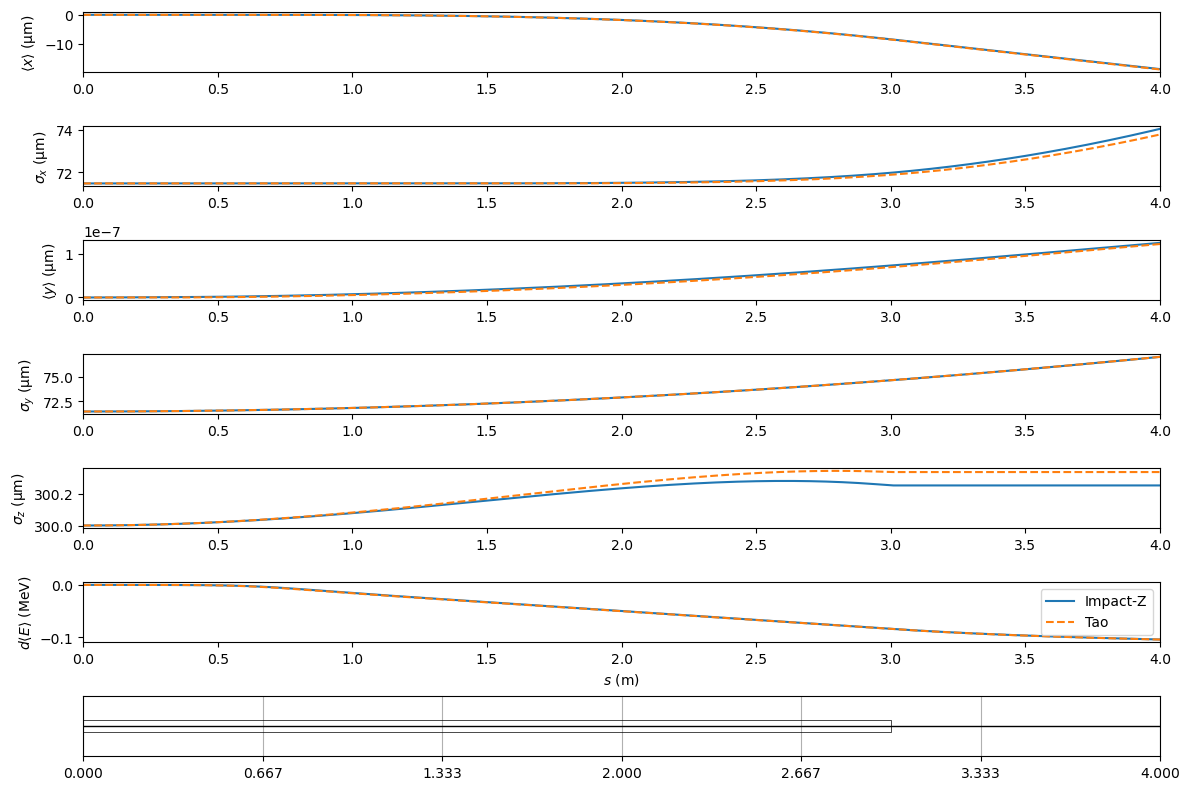

In [16]:
plot_impactz_and_tao_stats(I, tao)